In [210]:
import pandas as pd
from pathlib import Path
import plotnine as pn

let us load all relevant data for this task

In [211]:
base_path = Path("C:/Users/hanit/PycharmProjects/Vi/data")
base_path

WindowsPath('C:/Users/hanit/PycharmProjects/Vi/data')

In [212]:
web_visits_df = pd.read_csv(Path(base_path / 'web_visits.csv'))
app_usage_df = pd.read_csv(Path(base_path / 'app_usage.csv'))
claims_df = pd.read_csv(Path(base_path / 'claims.csv'))
churn_labels_df = pd.read_csv(Path(base_path / 'churn_labels.csv'))

Feature engeniring 

since I think there is a correlation between app or web visits (usage) frequency to churn I first want to calculate it per id from the data I have. 
since i assume there is no difference between app and web usage (or since i can cheack it later on) I'm going to union information from web_visits_df & app_usage_df:

In [213]:
web_app_usage_df = pd.concat([web_visits_df[['member_id','timestamp']], app_usage_df[['member_id','timestamp']]], ignore_index=True)

In [214]:
# Convert 'timestamp' column to datetime format:
web_app_usage_df["timestamp"] = pd.to_datetime(web_app_usage_df["timestamp"], errors="coerce")

# Group by 'member_id' and aggregate
result = web_app_usage_df.groupby("member_id").agg(
    timestamp_count=("timestamp", "count"),
    first_time=("timestamp", "min"),
    last_time=("timestamp", "max")
)

# Calculate the range of time (difference)
result["time_range"] = result["last_time"] - result["first_time"]

# Convert timedelta to days
result["time_range_days"] = result["time_range"].dt.total_seconds() / (24 * 60 * 60)

# calculate usage frequency (timestamps count per day)
result["frequency_per_day"] = result["timestamp_count"] / result["time_range_days"]

result.reset_index(inplace=True)

result

,member_id,timestamp_count,first_time,last_time,time_range,time_range_days,frequency_per_day
0,1,9,2025-07-02 11:30:47,2025-07-14 15:28:58,12 days 03:58:11,12.165405,0.739803
1,2,19,2025-07-01 00:37:35,2025-07-14 01:37:25,13 days 00:59:50,13.041551,1.456882
2,3,61,2025-07-01 07:12:25,2025-07-14 21:10:29,13 days 13:58:04,13.581991,4.491241
3,4,25,2025-07-01 10:39:28,2025-07-13 22:17:45,12 days 11:38:17,12.484919,2.002416
4,5,21,2025-07-01 08:40:53,2025-07-13 22:48:22,12 days 14:07:29,12.588530,1.668185
...,...,...,...,...,...,...,...
9995,9996,26,2025-07-01 01:48:31,2025-07-14 03:01:11,13 days 01:12:40,13.050463,1.992266
9996,9997,19,2025-07-01 04:00:51,2025-07-13 21:30:48,12 days 17:29:57,12.729132,1.492639
9997,9998,20,2025-07-01 04:40:55,2025-07-13 12:43:46,12 days 08:02:51,12.335313,1.621361
9998,9999,43,2025-07-01 01:30:35,2025-07-14 18:57:29,13 days 17:26:54,13.727014,3.132509


now lets graphicaly cheack if there is a diffrance between users usage with concerne to churn 

In [215]:
# first let us merge the churn dataframe into result dataframe by ID

result = pd.merge(result, churn_labels_df, how='left', on='member_id')

In [216]:
result['churn_catgory'] = result['churn'].astype('category')

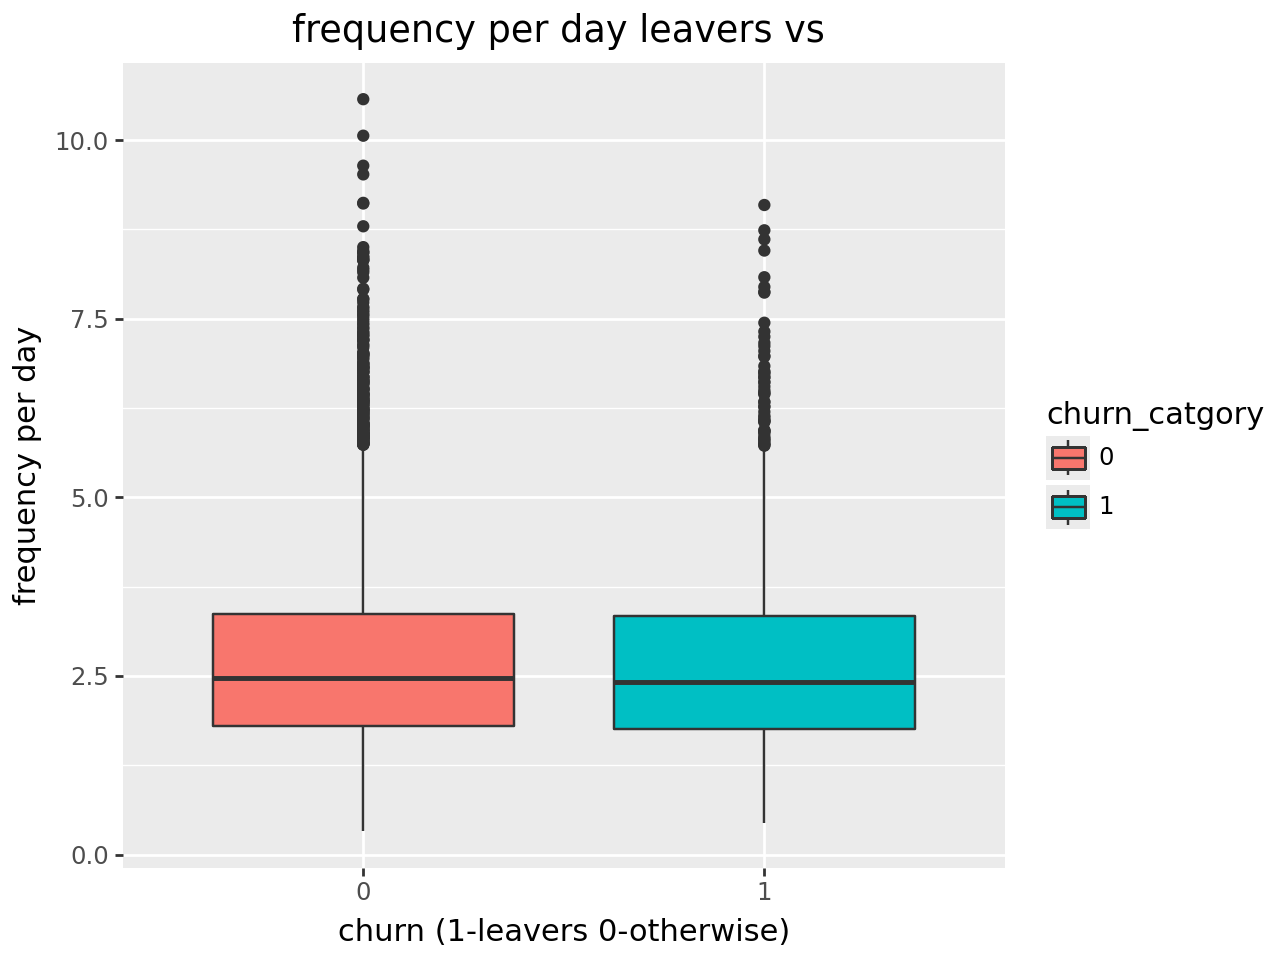

In [217]:
pn.ggplot(result, pn.aes(x='churn_catgory' ,y='frequency_per_day', fill='churn_catgory')) + \
    pn.geom_boxplot() + \
            pn.xlab('churn (1-leavers 0-otherwise)') + \
                pn.ylab('frequency per day') + \
                    pn.ggtitle('frequency per day leavers vs ') 
                    

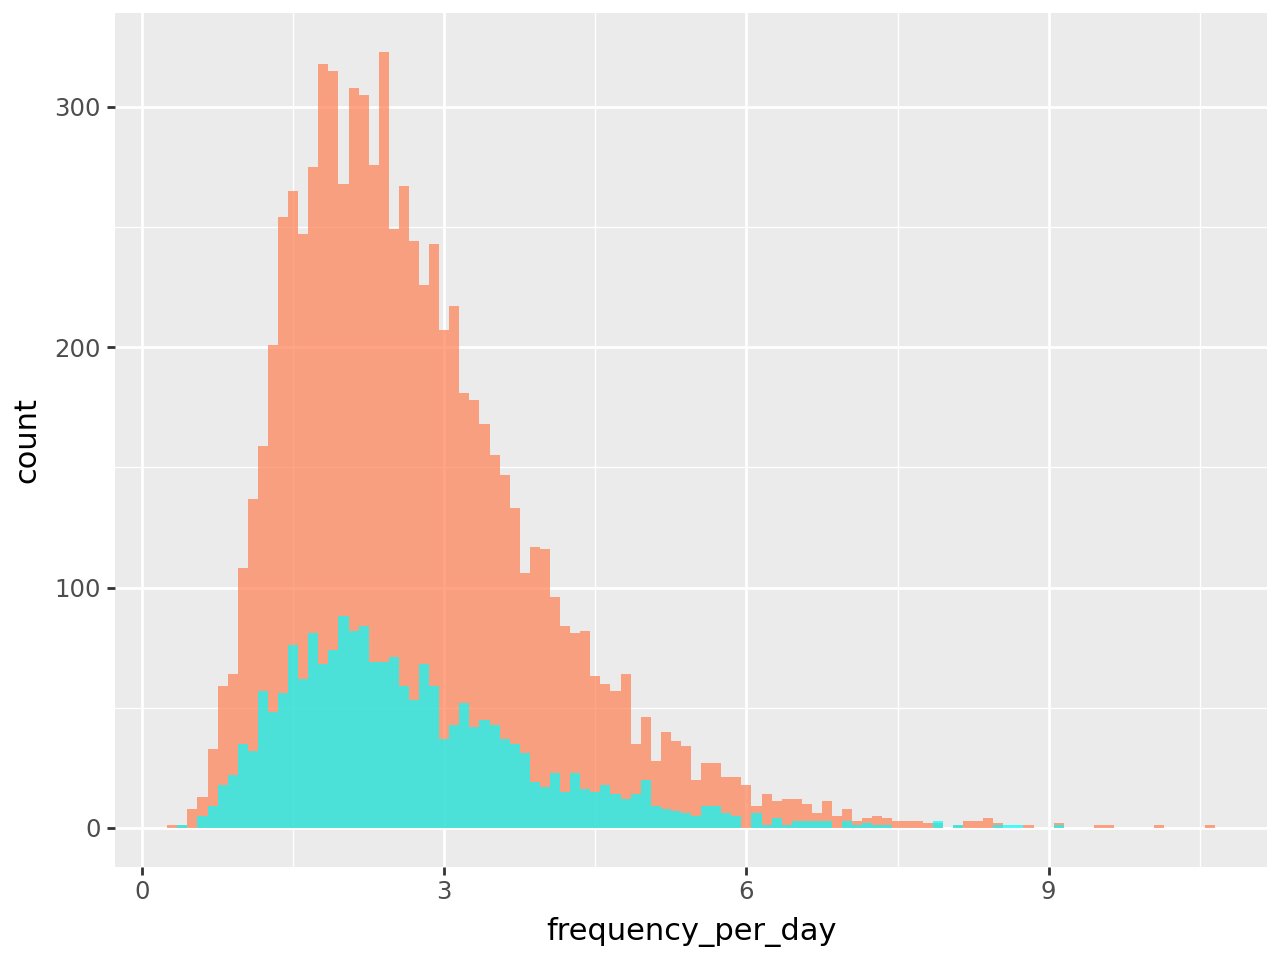

In [218]:
pn.ggplot() + \
    pn.geom_histogram(result.loc[result['churn_catgory']==0], pn.aes(x='frequency_per_day'), binwidth=0.1, fill = 'coral', alpha=0.7) + \
        pn.geom_histogram(result.loc[result['churn_catgory']==1], pn.aes(x='frequency_per_day'), binwidth=0.1, fill = 'aqua', alpha=0.7)



In [219]:
result.groupby("churn_catgory", observed=False)["frequency_per_day"].describe()

,count,mean,std,min,25%,50%,75%,max
churn_catgory,,,,,,,,
0,7979.0,2.713196,1.254186,0.328317,1.799918,2.470315,3.371364,10.574204
1,2021.0,2.673784,1.269378,0.435433,1.757013,2.420846,3.340713,9.093003


I checked visually the difference between users usage with concerne to churn (with a boxplot comparison and distribution comparison) and also with summary statistics (in the table above), it dosen't look like there is a significant diffrance. 
I could also cheack it ststisticaly, but the issue with such cheack that with large n it almost always shows significant diffrance.

now i want to cheack if there is a difference between app_usage between groups 
and if there is a difference between web visits between groups (i.e., this time im not going to union the information from both dataframes) 
this time I'm going to code it as a function since its becoming repeatedly used

In [220]:
def calculate_freq(df=df):

    # Convert 'timestamp' column to datetime format:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    
    # Group by 'member_id' and aggregate
    result = df.groupby("member_id").agg(
        timestamp_count=("timestamp", "count"),
        first_time=("timestamp", "min"),
        last_time=("timestamp", "max")
    )
    
    # Calculate the range of time (difference)
    result["time_range"] = result["last_time"] - result["first_time"]
    
    # Convert timedelta to days
    result["time_range_days"] = result["time_range"].dt.total_seconds() / (24 * 60 * 60)
    
    # calculate usage frequency (timestamps count per day)
    result["frequency_per_day"] = result["timestamp_count"] / result["time_range_days"]
    
    result.reset_index(inplace=True)
    
    return result

In [221]:
app_usage_freq_df = calculate_freq(app_usage_df[['member_id','timestamp']].reset_index())
web_usage_freq_df = calculate_freq(web_visits_df[['member_id','timestamp']].reset_index())

In [222]:
print(len(app_usage_freq_df))
print(len(web_usage_freq_df))

9998
9975


since there are users that might use only web or only app, I'm going to merge each off the above to id from result (where all users' ids are available)

In [223]:
app_usage_freq_df = pd.merge(pd.DataFrame(result[['member_id']]), app_usage_freq_df, how='left', on='member_id')

In [224]:
app_usage_freq_df["timestamp_count"].isna().sum()

np.int64(2)

In [225]:
app_usage_freq_df.loc[app_usage_freq_df["timestamp_count"].isna()]

,member_id,timestamp_count,first_time,last_time,time_range,time_range_days,frequency_per_day
5939,5940,NaN,NaT,NaT,NaT,NaN,NaN
7242,7243,NaN,NaT,NaT,NaT,NaN,NaN


In [226]:
web_usage_freq_df = pd.merge(pd.DataFrame(result[['member_id']]), web_usage_freq_df, how='left', on='member_id')

In [227]:
web_usage_freq_df["timestamp_count"].isna().sum()

np.int64(25)

In [228]:
web_usage_freq_df.loc[web_usage_freq_df["timestamp_count"].isna()]

,member_id,timestamp_count,first_time,last_time,time_range,time_range_days,frequency_per_day
127,128,NaN,NaT,NaT,NaT,NaN,NaN
250,251,NaN,NaT,NaT,NaT,NaN,NaN
341,342,NaN,NaT,NaT,NaT,NaN,NaN
656,657,NaN,NaT,NaT,NaT,NaN,NaN
1283,1284,NaN,NaT,NaT,NaT,NaN,NaN
1713,1714,NaN,NaT,NaT,NaT,NaN,NaN
2394,2395,NaN,NaT,NaT,NaT,NaN,NaN
3300,3301,NaN,NaT,NaT,NaT,NaN,NaN
3506,3507,NaN,NaT,NaT,NaT,NaN,NaN
3547,3548,NaN,NaT,NaT,NaT,NaN,NaN


In [229]:
app_usage_freq_df["frequency_per_day"]

0       0.507469
1       0.850265
2       0.858591
3       0.800966
4       0.796222
          ...   
9995    0.853659
9996    1.008425
9997    1.206117
9998    0.653204
9999    1.062035
Name: frequency_per_day, Length: 10000, dtype: float64

In [230]:
app_usage_freq_df["frequency_per_day"] = app_usage_freq_df["frequency_per_day"].fillna(0)
web_usage_freq_df["frequency_per_day"] = web_usage_freq_df["frequency_per_day"].fillna(0)
app_usage_freq_df.loc[app_usage_freq_df["timestamp_count"].isna()]

,member_id,timestamp_count,first_time,last_time,time_range,time_range_days,frequency_per_day
5939,5940,NaN,NaT,NaT,NaT,NaN,0.0
7242,7243,NaN,NaT,NaT,NaT,NaN,0.0


In [231]:
app_usage_freq_df = pd.merge(app_usage_freq_df, churn_labels_df, how='left', on='member_id')


In [232]:
app_usage_freq_df

,member_id,timestamp_count,first_time,last_time,time_range,time_range_days,frequency_per_day,signup_date,churn,outreach
0,1,6.0,2025-07-02 19:43:17,2025-07-14 15:28:58,11 days 19:45:41,11.823391,0.507469,2024-04-12,0,0
1,2,10.0,2025-07-02 07:21:31,2025-07-14 01:37:25,11 days 18:15:54,11.761042,0.850265,2025-03-11,0,0
2,3,9.0,2025-07-01 18:07:50,2025-07-12 05:42:20,10 days 11:34:30,10.482292,0.858591,2024-09-27,0,0
3,4,10.0,2025-07-01 10:39:28,2025-07-13 22:17:45,12 days 11:38:17,12.484919,0.800966,2024-04-16,1,0
4,5,10.0,2025-07-01 08:40:53,2025-07-13 22:06:17,12 days 13:25:24,12.559306,0.796222,2024-03-12,0,1
...,...,...,...,...,...,...,...,...,...,...
9995,9996,8.0,2025-07-04 18:06:20,2025-07-14 03:01:11,9 days 08:54:51,9.371424,0.853659,2024-09-02,0,0
9996,9997,11.0,2025-07-02 23:43:08,2025-07-13 21:30:48,10 days 21:47:40,10.908102,1.008425,2024-02-07,0,0
9997,9998,12.0,2025-07-01 21:43:50,2025-07-11 20:30:48,9 days 22:46:58,9.949282,1.206117,2024-09-01,0,0
9998,9999,7.0,2025-07-03 04:37:24,2025-07-13 21:49:01,10 days 17:11:37,10.716400,0.653204,2024-01-21,0,0


C:\Users\hanit\miniconda3\envs\tf_env\Lib\site-packages\plotnine\layer.py:293: PlotnineWarning: stat_boxplot : Removed 12 rows containing non-finite values.


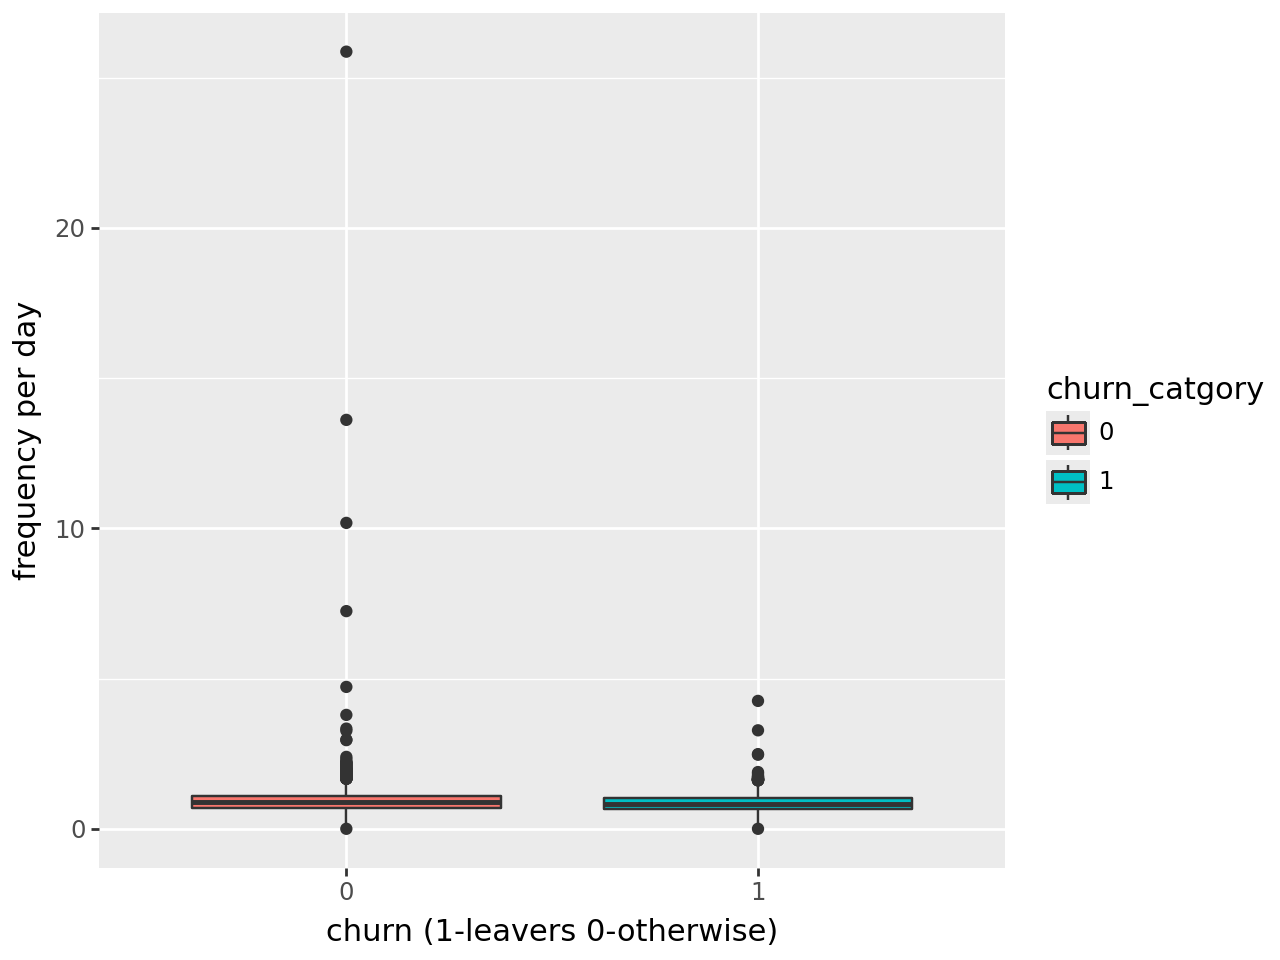

In [233]:
app_usage_freq_df['churn_catgory'] = app_usage_freq_df['churn'].astype('category')

pn.ggplot(app_usage_freq_df, pn.aes(x='churn_catgory' ,y='frequency_per_day', fill='churn_catgory')) + \
    pn.geom_boxplot() + \
            pn.xlab('churn (1-leavers 0-otherwise)') + \
                pn.ylab('frequency per day') 


In [234]:
import numpy as np

app_usage_freq_df[np.isinf(app_usage_freq_df["frequency_per_day"])]


,member_id,timestamp_count,first_time,last_time,time_range,time_range_days,frequency_per_day,signup_date,churn,outreach,churn_catgory
49,50,1.0,2025-07-04 03:01:50,2025-07-04 03:01:50,0 days,0.0,inf,2025-05-23,1,0,1
571,572,1.0,2025-07-01 07:02:58,2025-07-01 07:02:58,0 days,0.0,inf,2025-03-10,1,1,1
1633,1634,1.0,2025-07-10 12:53:00,2025-07-10 12:53:00,0 days,0.0,inf,2025-05-29,1,0,1
1894,1895,1.0,2025-07-08 13:57:43,2025-07-08 13:57:43,0 days,0.0,inf,2024-05-15,1,1,1
2875,2876,1.0,2025-07-10 19:07:29,2025-07-10 19:07:29,0 days,0.0,inf,2025-02-23,1,1,1
3517,3518,1.0,2025-07-06 05:34:16,2025-07-06 05:34:16,0 days,0.0,inf,2024-01-11,1,1,1
4248,4249,1.0,2025-07-09 09:33:31,2025-07-09 09:33:31,0 days,0.0,inf,2025-05-30,0,0,0
4892,4893,1.0,2025-07-09 19:20:20,2025-07-09 19:20:20,0 days,0.0,inf,2024-12-02,0,1,0
5011,5012,1.0,2025-07-11 10:51:15,2025-07-11 10:51:15,0 days,0.0,inf,2024-05-28,1,1,1
6025,6026,1.0,2025-07-04 10:17:22,2025-07-04 10:17:22,0 days,0.0,inf,2025-05-12,0,0,0


In [235]:
app_usage_freq_df[np.isinf(app_usage_freq_df["frequency_per_day"])].shape

(12, 11)

In [236]:
app_usage_freq_df.groupby("churn_catgory", observed=False)["frequency_per_day"].describe()

C:\Users\hanit\miniconda3\envs\tf_env\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
C:\Users\hanit\miniconda3\envs\tf_env\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract


,count,mean,std,min,25%,50%,75%,max
churn_catgory,,,,,,,,
0,7979.0,inf,NaN,0.0,0.693316,0.881111,1.081895,inf
1,2021.0,inf,NaN,0.0,0.652576,0.829183,1.037284,inf


In [237]:
result.groupby("churn_catgory", observed=False)["time_range_days"].describe()

,count,mean,std,min,25%,50%,75%,max
churn_catgory,,,,,,,,
0,7979.0,13.047216,0.864392,3.169282,12.756134,13.302257,13.630440,13.995174
1,2021.0,13.017988,0.905650,5.887558,12.686690,13.284352,13.614641,13.998993


In [238]:
result.groupby("churn_catgory", observed=False)["first_time"].describe()

,count,mean,min,25%,50%,75%,max
churn_catgory,,,,,,,
0,7979,2025-07-01 11:23:35.928061184,2025-07-01 00:00:00,2025-07-01 02:41:49,2025-07-01 06:47:17,2025-07-01 14:48:50.500000,2025-07-08 06:07:21
1,2021,2025-07-01 12:00:49.443344896,2025-07-01 00:00:02,2025-07-01 03:00:35,2025-07-01 06:51:50,2025-07-01 15:20:09,2025-07-08 06:04:04


In [239]:
result.groupby("churn_catgory", observed=False)["last_time"].describe()

,count,mean,min,25%,50%,75%,max
churn_catgory,,,,,,,
0,7979,2025-07-14 12:31:35.376488192,2025-07-07 12:00:50,2025-07-14 09:02:17,2025-07-14 16:59:56,2025-07-14 21:07:36.500000,2025-07-14 23:59:51
1,2021,2025-07-14 12:26:43.627411968,2025-07-08 13:57:43,2025-07-14 09:06:59,2025-07-14 16:40:20,2025-07-14 21:05:45,2025-07-14 23:59:49


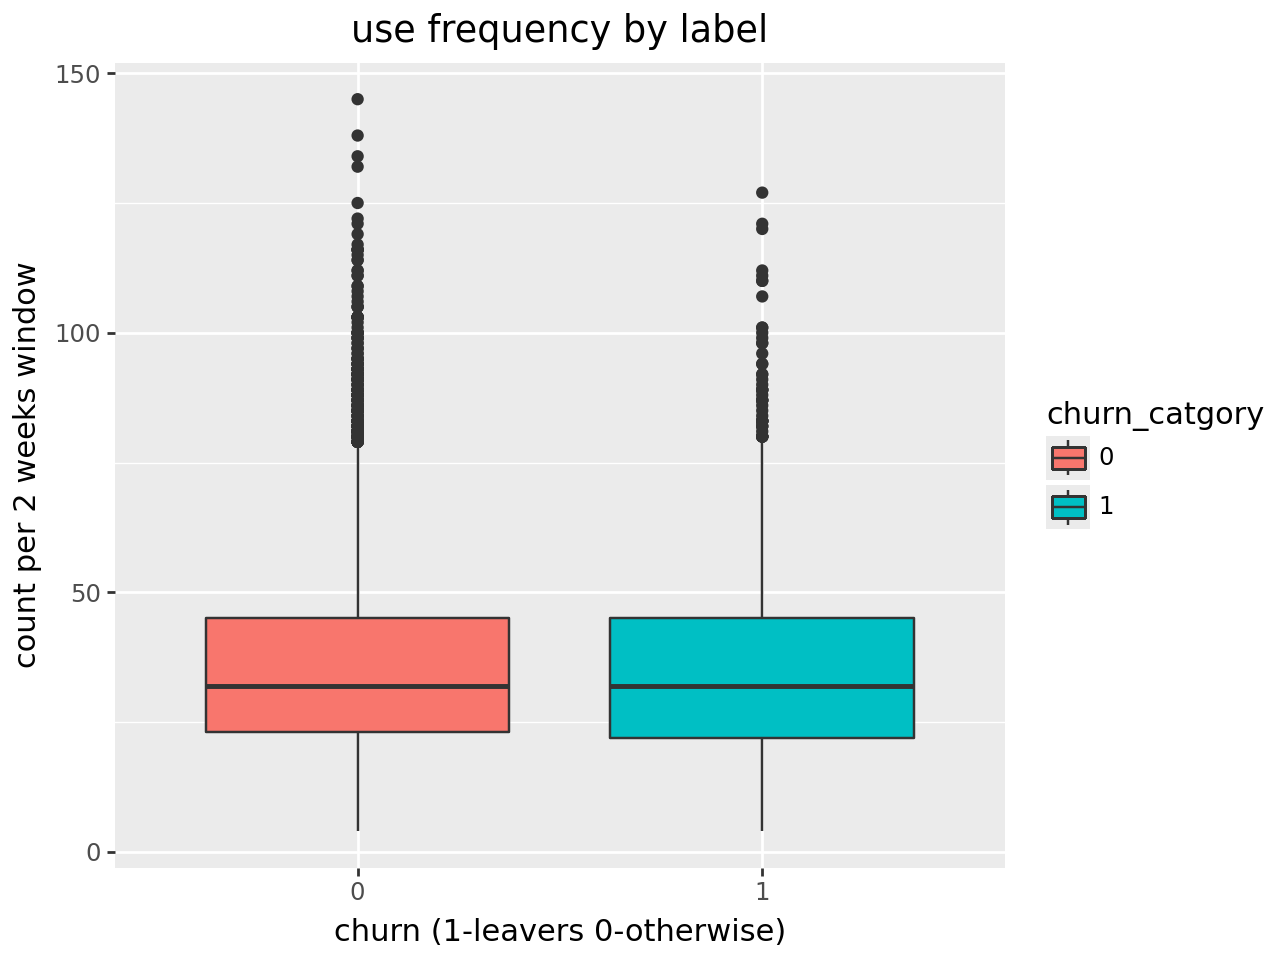

In [240]:
pn.ggplot(result, pn.aes(x='churn_catgory' ,y='timestamp_count', fill='churn_catgory')) + \
    pn.geom_boxplot() + \
            pn.xlab('churn (1-leavers 0-otherwise)') + \
                pn.ylab('count per 2 weeks window') + \
                    pn.ggtitle('use frequency by label') 
                    

In [241]:
result.groupby("churn_catgory", observed=False)["timestamp_count"].describe()

,count,mean,std,min,25%,50%,75%,max
churn_catgory,,,,,,,,
0,7979.0,35.828675,17.558493,4.0,23.0,32.0,45.0,145.0
1,2021.0,35.255814,17.738373,4.0,22.0,32.0,45.0,127.0


In [242]:
result.groupby("churn_catgory", observed=False)["time_range_days"].describe()

,count,mean,std,min,25%,50%,75%,max
churn_catgory,,,,,,,,
0,7979.0,13.047216,0.864392,3.169282,12.756134,13.302257,13.630440,13.995174
1,2021.0,13.017988,0.905650,5.887558,12.686690,13.284352,13.614641,13.998993


In [243]:
result['signup_date']

0       2024-04-12
1       2025-03-11
2       2024-09-27
3       2024-04-16
4       2024-03-12
           ...    
9995    2024-09-02
9996    2024-02-07
9997    2024-09-01
9998    2024-01-21
9999    2024-04-19
Name: signup_date, Length: 10000, dtype: object

In [244]:
result["signup_date"] = pd.to_datetime(result["signup_date"], format="%Y-%m-%d")
result["signup_date"]

0      2024-04-12
1      2025-03-11
2      2024-09-27
3      2024-04-16
4      2024-03-12
          ...    
9995   2024-09-02
9996   2024-02-07
9997   2024-09-01
9998   2024-01-21
9999   2024-04-19
Name: signup_date, Length: 10000, dtype: datetime64[ns]

In [245]:

result["days_since_signup"] = (result["last_time"] - result["signup_date"]).dt.days
result


,member_id,timestamp_count,first_time,last_time,time_range,time_range_days,frequency_per_day,signup_date,churn,outreach,churn_catgory,days_since_signup
0,1,9,2025-07-02 11:30:47,2025-07-14 15:28:58,12 days 03:58:11,12.165405,0.739803,2024-04-12,0,0,0,458
1,2,19,2025-07-01 00:37:35,2025-07-14 01:37:25,13 days 00:59:50,13.041551,1.456882,2025-03-11,0,0,0,125
2,3,61,2025-07-01 07:12:25,2025-07-14 21:10:29,13 days 13:58:04,13.581991,4.491241,2024-09-27,0,0,0,290
3,4,25,2025-07-01 10:39:28,2025-07-13 22:17:45,12 days 11:38:17,12.484919,2.002416,2024-04-16,1,0,1,453
4,5,21,2025-07-01 08:40:53,2025-07-13 22:48:22,12 days 14:07:29,12.588530,1.668185,2024-03-12,0,1,0,488
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,26,2025-07-01 01:48:31,2025-07-14 03:01:11,13 days 01:12:40,13.050463,1.992266,2024-09-02,0,0,0,315
9996,9997,19,2025-07-01 04:00:51,2025-07-13 21:30:48,12 days 17:29:57,12.729132,1.492639,2024-02-07,0,0,0,522
9997,9998,20,2025-07-01 04:40:55,2025-07-13 12:43:46,12 days 08:02:51,12.335313,1.621361,2024-09-01,0,0,0,315
9998,9999,43,2025-07-01 01:30:35,2025-07-14 18:57:29,13 days 17:26:54,13.727014,3.132509,2024-01-21,0,0,0,540


In [300]:
result.groupby("churn_catgory", observed=False)["days_since_signup"].describe()

,count,mean,std,min,25%,50%,75%,max
churn_catgory,,,,,,,,
0,51772.0,314.166944,146.816521,43.0,189.0,319.0,443.0,560.0
1,12824.0,264.247193,149.302370,42.0,133.0,247.0,391.0,560.0


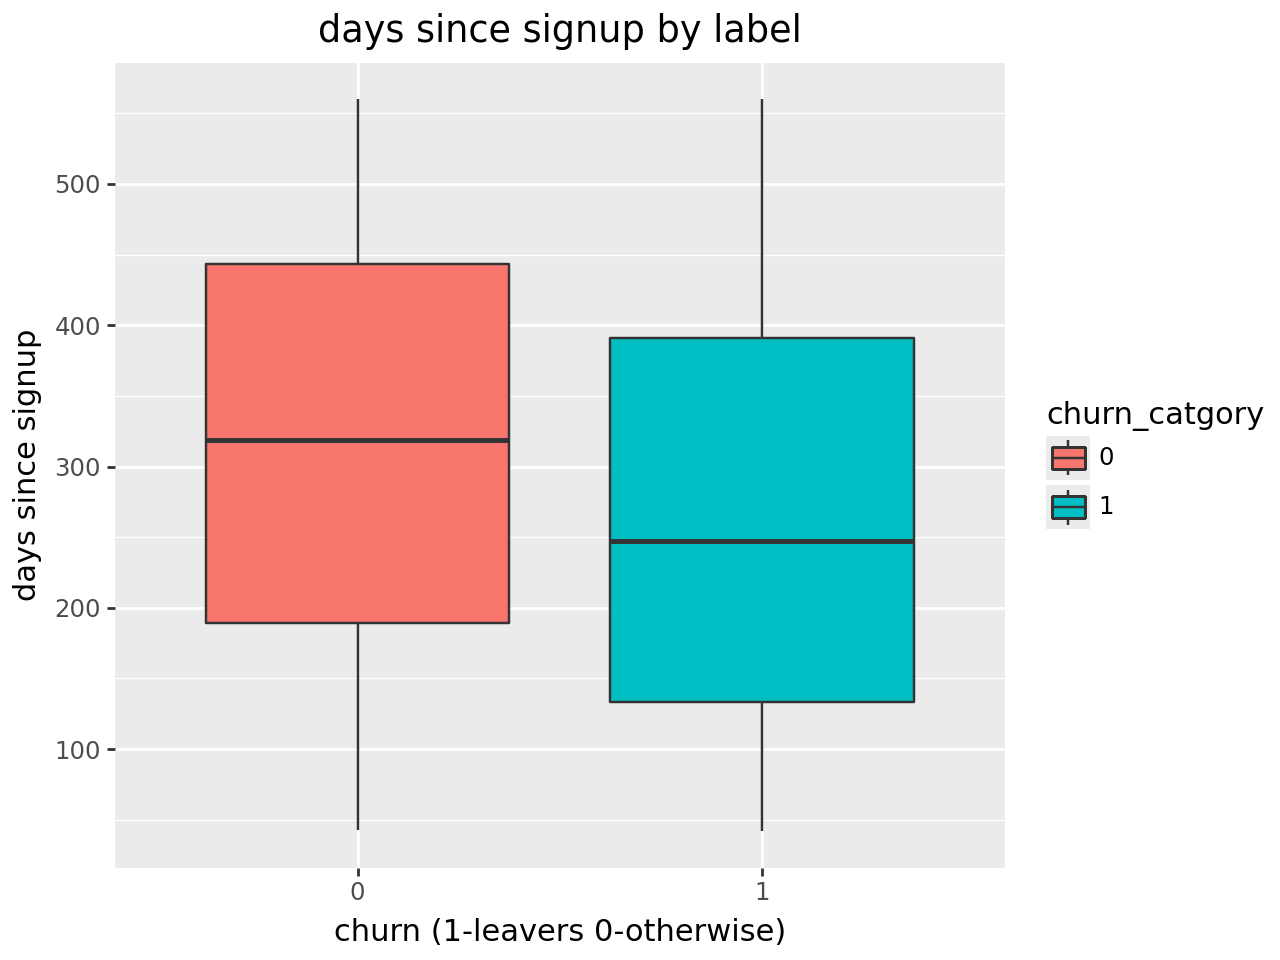

In [301]:
pn.ggplot(result, pn.aes(x='churn_catgory' ,y='days_since_signup', fill='churn_catgory')) + \
    pn.geom_boxplot() + \
            pn.xlab('churn (1-leavers 0-otherwise)') + \
                pn.ylab('days since signup') + \
                    pn.ggtitle('days since signup by label') 

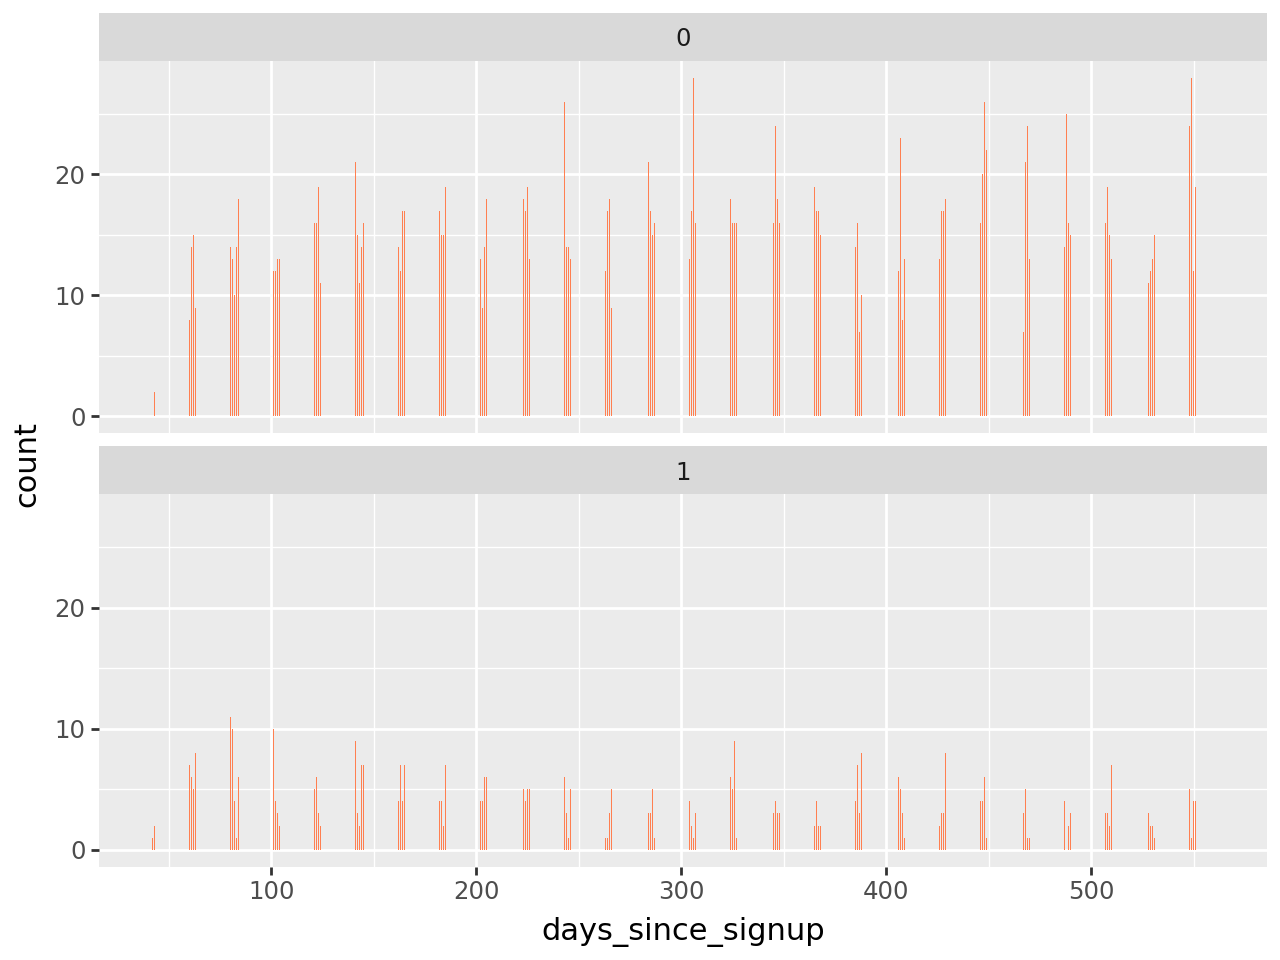

In [247]:
pn.ggplot() + \
    pn.geom_histogram(result, pn.aes(x='days_since_signup'), binwidth=0.1, fill = 'coral') + \
        pn.facet_wrap('churn_catgory', nrow=2)


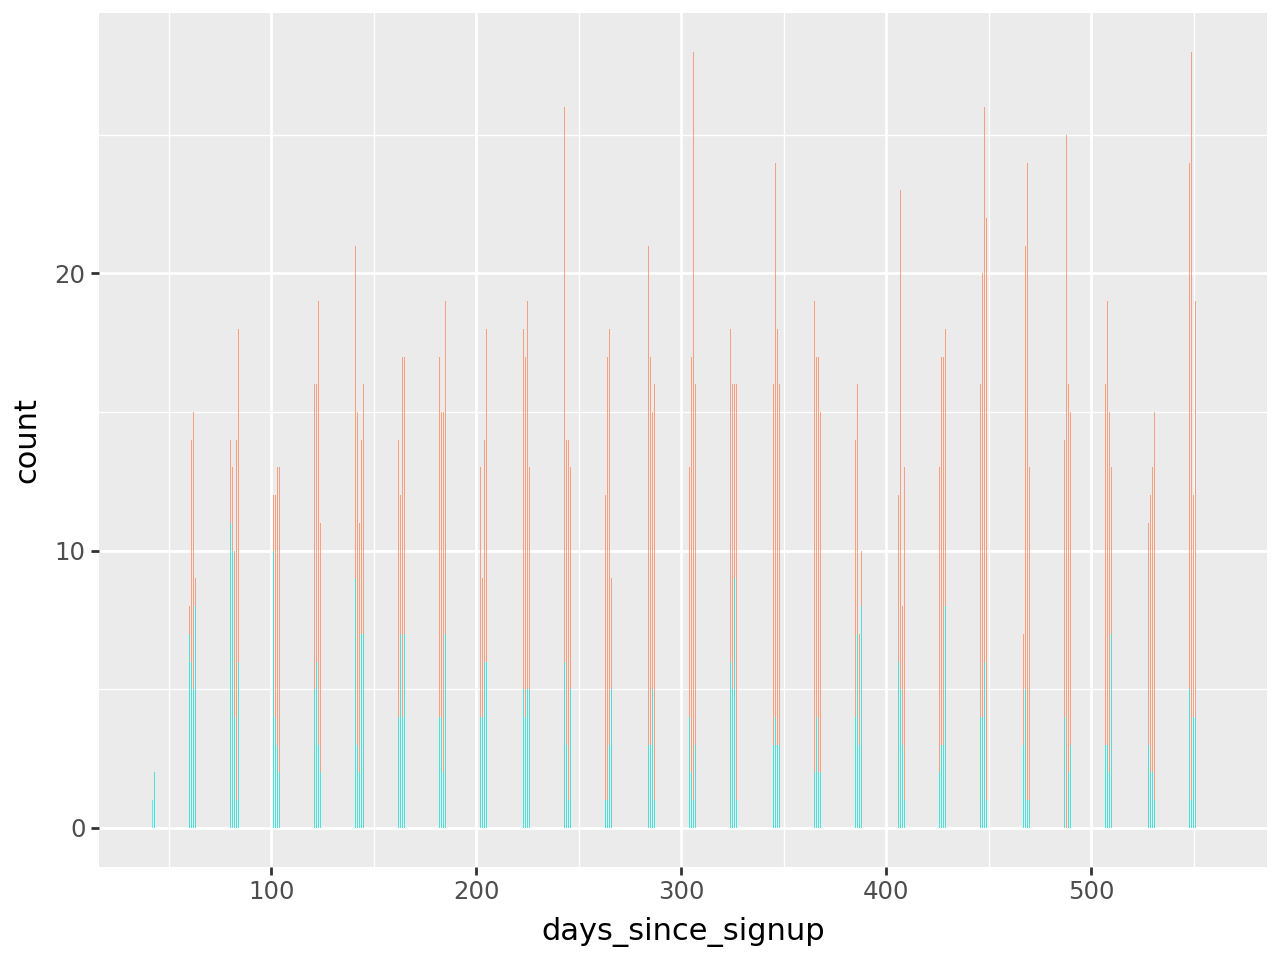

In [248]:
pn.ggplot() + \
    pn.geom_histogram(result.loc[result['churn_catgory']==0], pn.aes(x='days_since_signup'), binwidth=0.1, fill = 'coral', alpha=0.7) + \
        pn.geom_histogram(result.loc[result['churn_catgory']==1], pn.aes(x='days_since_signup'), binwidth=0.1, fill = 'aqua', alpha=0.7)



In [249]:
result.groupby("churn_catgory", observed=False)["days_since_signup"].describe()

,count,mean,std,min,25%,50%,75%,max
churn_catgory,,,,,,,,
0,7979.0,312.751974,147.382195,43.0,186.0,318.0,442.0,560.0
1,2021.0,261.739238,149.974905,42.0,127.0,243.0,388.0,560.0


In [250]:
result["days_since_signup_cut"] = pd.cut(result["days_since_signup"],
                                bins=[100, 150, 200, 250, 300, 350, 400, 450, 500, 560],
                                    labels=[100, 150,200, 250, 300, 350, 400, 450, 500])

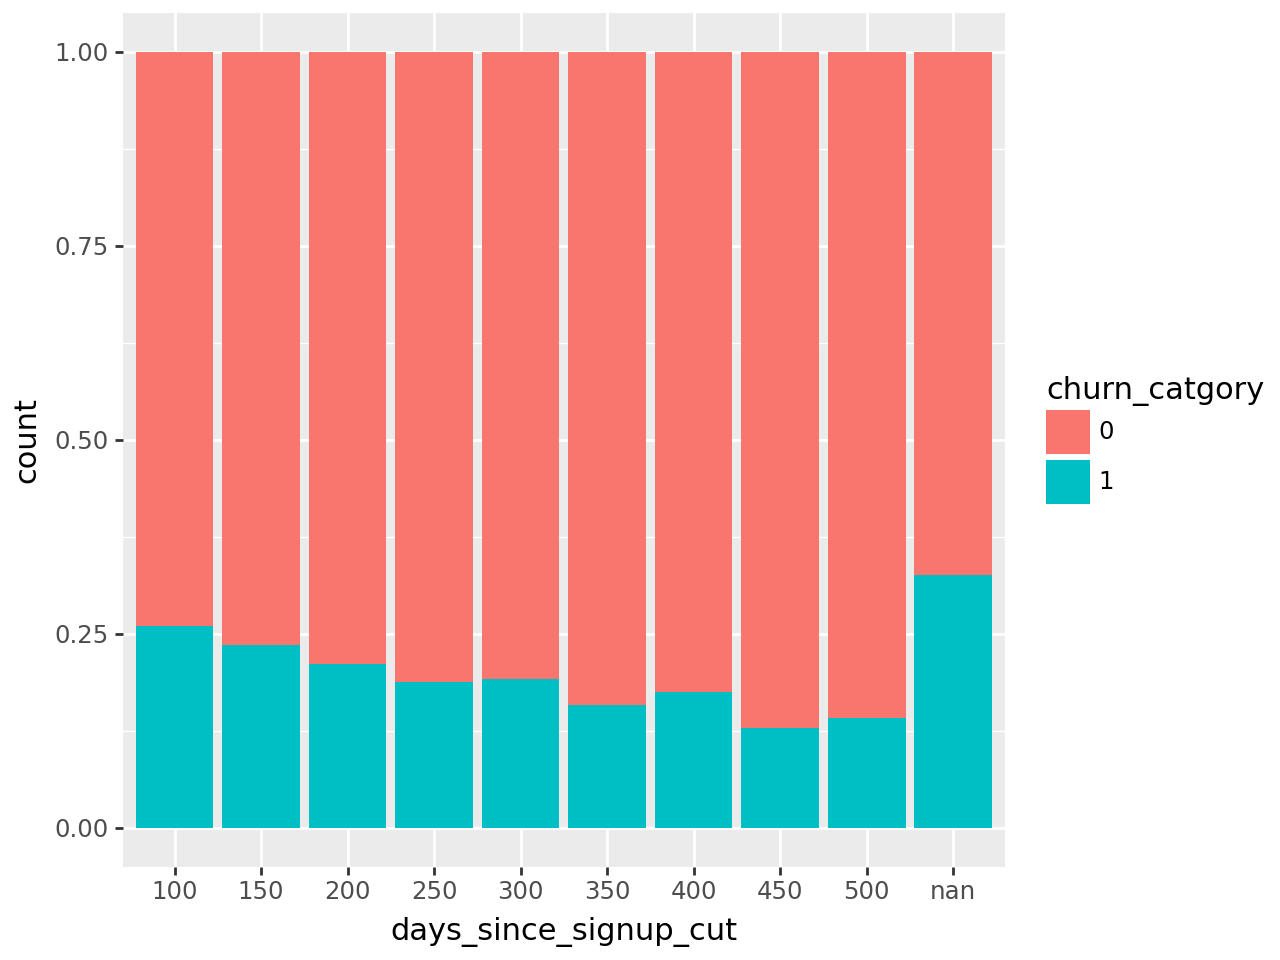

In [251]:
import plotnine as pn

result['days_since_signup_cut'] = result['days_since_signup_cut'].astype('category')

pn.ggplot(result, pn.aes(x='days_since_signup_cut', fill = 'churn_catgory')) + pn.geom_bar(position = "fill") 

In [252]:
result = pd.merge(result, claims_df, how='left', on='member_id')

In [255]:
result

,member_id,timestamp_count,first_time,last_time,time_range,time_range_days,frequency_per_day,signup_date,churn,outreach,churn_catgory,days_since_signup,days_since_signup_cut,icd_code,diagnosis_date,icd_code_cat
0,1,9,2025-07-02 11:30:47,2025-07-14 15:28:58,12 days 03:58:11,12.165405,0.739803,2024-04-12,0,0,0,458,450,Z71.3,2025-07-09,Z71.3
1,1,9,2025-07-02 11:30:47,2025-07-14 15:28:58,12 days 03:58:11,12.165405,0.739803,2024-04-12,0,0,0,458,450,Z71.3,2025-07-14,Z71.3
2,1,9,2025-07-02 11:30:47,2025-07-14 15:28:58,12 days 03:58:11,12.165405,0.739803,2024-04-12,0,0,0,458,450,J00,2025-07-12,J00
3,1,9,2025-07-02 11:30:47,2025-07-14 15:28:58,12 days 03:58:11,12.165405,0.739803,2024-04-12,0,0,0,458,450,M54.5,2025-07-01,M54.5
4,1,9,2025-07-02 11:30:47,2025-07-14 15:28:58,12 days 03:58:11,12.165405,0.739803,2024-04-12,0,0,0,458,450,I10,2025-07-12,I10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64591,10000,62,2025-07-01 03:49:57,2025-07-14 19:23:08,13 days 15:33:11,13.648044,4.542776,2024-04-19,0,1,0,451,450,B34.9,2025-07-06,B34.9
64592,10000,62,2025-07-01 03:49:57,2025-07-14 19:23:08,13 days 15:33:11,13.648044,4.542776,2024-04-19,0,1,0,451,450,A09,2025-07-12,A09
64593,10000,62,2025-07-01 03:49:57,2025-07-14 19:23:08,13 days 15:33:11,13.648044,4.542776,2024-04-19,0,1,0,451,450,R51,2025-07-03,R51
64594,10000,62,2025-07-01 03:49:57,2025-07-14 19:23:08,13 days 15:33:11,13.648044,4.542776,2024-04-19,0,1,0,451,450,J00,2025-07-08,J00


In [254]:
result['icd_code_cat'] = result['icd_code'].astype('category')

In [256]:
result

,member_id,timestamp_count,first_time,last_time,time_range,time_range_days,frequency_per_day,signup_date,churn,outreach,churn_catgory,days_since_signup,days_since_signup_cut,icd_code,diagnosis_date,icd_code_cat
0,1,9,2025-07-02 11:30:47,2025-07-14 15:28:58,12 days 03:58:11,12.165405,0.739803,2024-04-12,0,0,0,458,450,Z71.3,2025-07-09,Z71.3
1,1,9,2025-07-02 11:30:47,2025-07-14 15:28:58,12 days 03:58:11,12.165405,0.739803,2024-04-12,0,0,0,458,450,Z71.3,2025-07-14,Z71.3
2,1,9,2025-07-02 11:30:47,2025-07-14 15:28:58,12 days 03:58:11,12.165405,0.739803,2024-04-12,0,0,0,458,450,J00,2025-07-12,J00
3,1,9,2025-07-02 11:30:47,2025-07-14 15:28:58,12 days 03:58:11,12.165405,0.739803,2024-04-12,0,0,0,458,450,M54.5,2025-07-01,M54.5
4,1,9,2025-07-02 11:30:47,2025-07-14 15:28:58,12 days 03:58:11,12.165405,0.739803,2024-04-12,0,0,0,458,450,I10,2025-07-12,I10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64591,10000,62,2025-07-01 03:49:57,2025-07-14 19:23:08,13 days 15:33:11,13.648044,4.542776,2024-04-19,0,1,0,451,450,B34.9,2025-07-06,B34.9
64592,10000,62,2025-07-01 03:49:57,2025-07-14 19:23:08,13 days 15:33:11,13.648044,4.542776,2024-04-19,0,1,0,451,450,A09,2025-07-12,A09
64593,10000,62,2025-07-01 03:49:57,2025-07-14 19:23:08,13 days 15:33:11,13.648044,4.542776,2024-04-19,0,1,0,451,450,R51,2025-07-03,R51
64594,10000,62,2025-07-01 03:49:57,2025-07-14 19:23:08,13 days 15:33:11,13.648044,4.542776,2024-04-19,0,1,0,451,450,J00,2025-07-08,J00


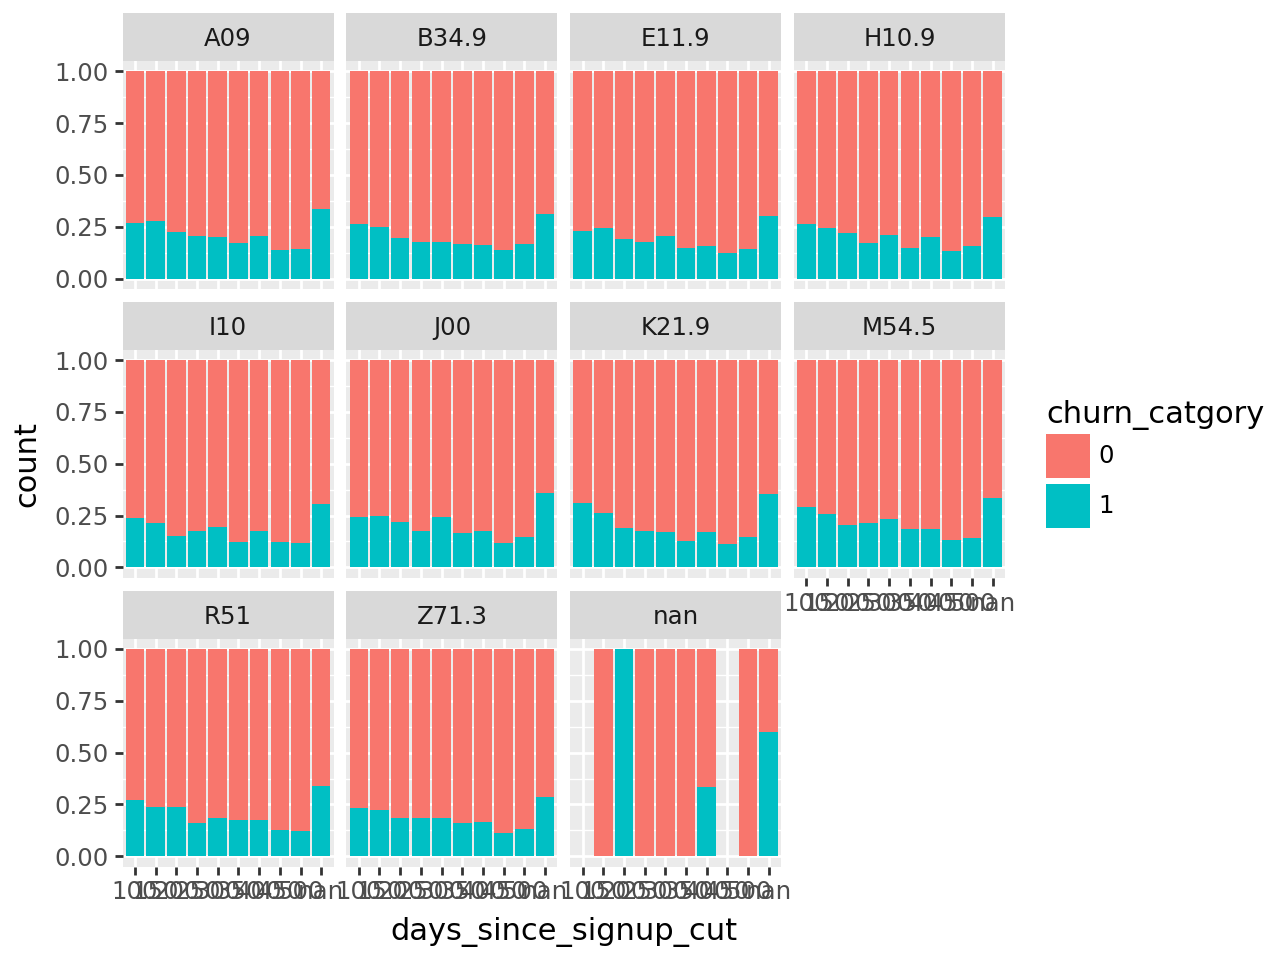

In [257]:
pn.ggplot(result, pn.aes(x='days_since_signup_cut', fill = 'churn_catgory')) + pn.geom_bar(position = "fill") +  pn.facet_wrap('icd_code_cat')

In [258]:
claims_df['icd_code'].unique()

array(['Z71.3', 'J00', 'M54.5', 'I10', 'E11.9', 'K21.9', 'R51', 'A09',
       'B34.9', 'H10.9'], dtype=object)

In [272]:
claims_df_totals = claims_df[['member_id','icd_code']].groupby(['member_id','icd_code']).size().reset_index(name='is_icd_code')
claims_df_totals['is_icd_code'] = np.where(claims_df_totals['is_icd_code']>0,1,0)
claims_df_totals

,member_id,icd_code,is_icd_code
0,1,E11.9,1
1,1,I10,1
2,1,J00,1
3,1,M54.5,1
4,1,Z71.3,1
...,...,...,...
46525,10000,B34.9,1
46526,10000,J00,1
46527,10000,M54.5,1
46528,10000,R51,1


In [ ]:
claims_df_totals[]

In [274]:
claims_df_wide = claims_df_totals.pivot(index='member_id', columns='icd_code', values='is_icd_code')
claims_df_wide = claims_df_wide.fillna(0)

In [275]:
claims_df_wide

icd_code,A09,B34.9,E11.9,H10.9,I10,J00,K21.9,M54.5,R51,Z71.3
member_id,,,,,,,,,,
1,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
2,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
9996,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
9997,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
9998,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [277]:
claims_df_wide

icd_code,A09,B34.9,E11.9,H10.9,I10,J00,K21.9,M54.5,R51,Z71.3
member_id,,,,,,,,,,
1,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
2,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
9996,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
9997,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
9998,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [278]:
claims_df_wide.columns.name  = None
claims_df_wide.reset_index(inplace=True)

In [282]:
claims_df_wide

,member_id,A09,B34.9,E11.9,H10.9,I10,J00,K21.9,M54.5,R51,Z71.3
0,1,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
1,2,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
2,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
9975,9996,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
9976,9997,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
9977,9998,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
9978,9999,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0


# Z71.3 - Dietary counseling and surveillance
J00 - Acute nasopharyngitis [common cold]
M54.5 - Low back pain
# I10 - Essential (primary) hypertension
# E11.9 - Type 2 diabetes mellitus without complications
K21.9 - Gastro-esophageal reflux disease without esophagitis
R51 - Headache
A09 - Infectious gastroenteritis and colitis, unspecified


In [283]:
claims_df_wide.columns

Index(['member_id', 'A09', 'B34.9', 'E11.9', 'H10.9', 'I10', 'J00', 'K21.9',
       'M54.5', 'R51', 'Z71.3'],
      dtype='object')

In [289]:
claims_df_wide['populations_of_interest'] = np.where(claims_df_wide.loc[[claims_df_wide['Z71.3']>0],1,0)

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (2763305507.py, line 1)

In [290]:
claims_df_wide['populations_of_interest'] = np.where((claims_df_wide['Z71.3']>0)|
                                                     (claims_df_wide['I10']>0)|
                                                     (claims_df_wide['E11.9']>0),1,0)
claims_df_wide

,member_id,A09,B34.9,E11.9,H10.9,I10,J00,K21.9,M54.5,R51,Z71.3,populations_of_interest
0,1,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1
1,2,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1
2,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1
3,4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1
4,5,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9975,9996,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1
9976,9997,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1
9977,9998,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1
9978,9999,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1


In [294]:
result = pd.merge(result, claims_df_wide[['member_id','populations_of_interest']], how='left', on='member_id')
result['populations_of_interest_cat'] = result['populations_of_interest'].astype('category')

In [ ]:
result['icd_code_cat'] = result['icd_code'].astype('category')

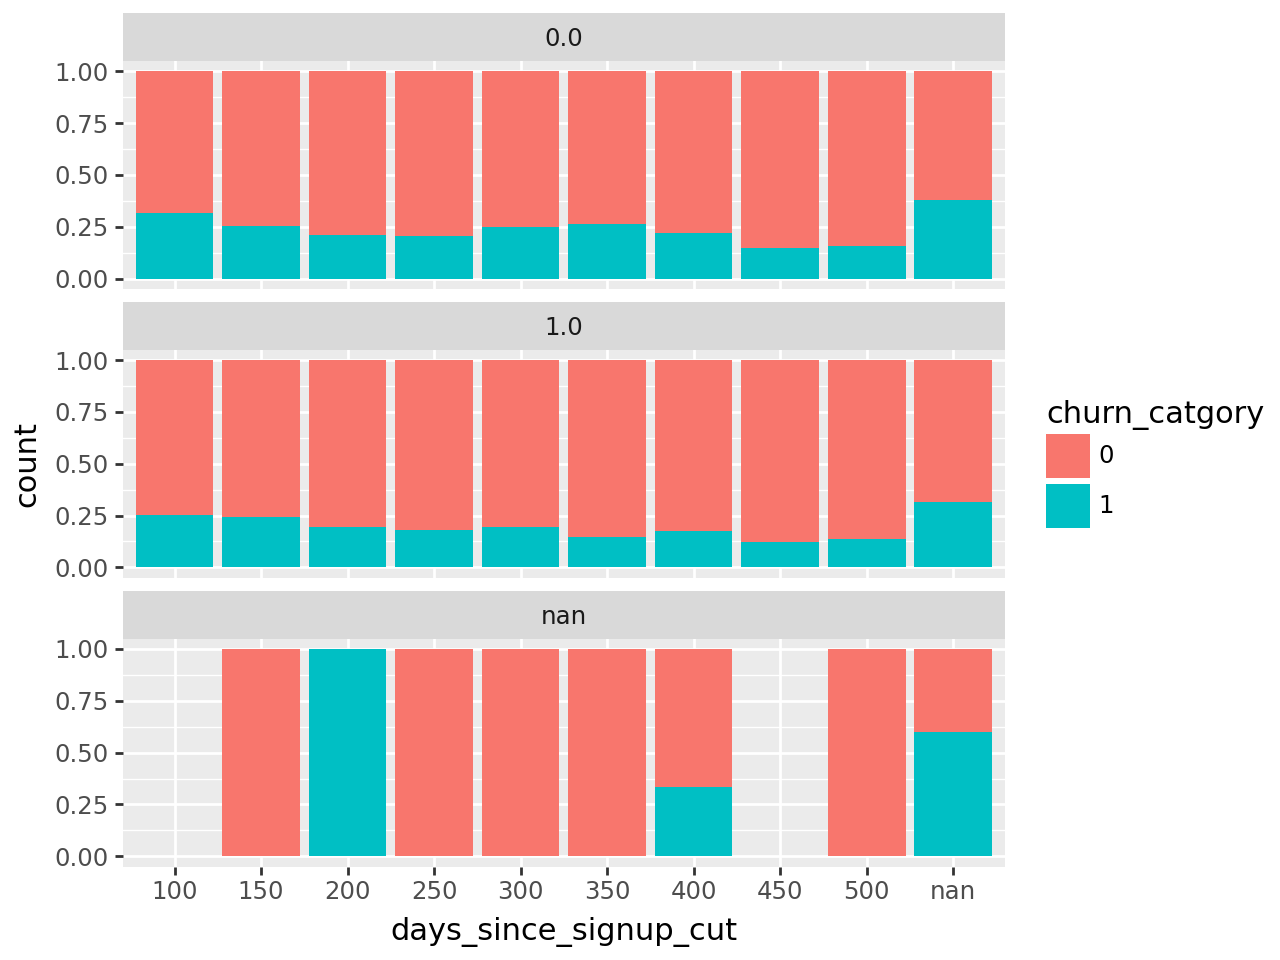

In [296]:
pn.ggplot(result, pn.aes(x='days_since_signup_cut', fill = 'churn_catgory')) + pn.geom_bar(position = "fill") +  pn.facet_wrap('populations_of_interest_cat', nrow=3)

In [299]:
result.loc[result['icd_code_cat'].isna()

(20, 18)

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-colorblind")
sns.set_style("darkgrid")
sns.set_context("notebook")

In [2]:
from lifelines.datasets import load_waltons
df = load_waltons() # returns a Pandas DataFrame

print(df.head())

      T  E    group
0   6.0  1  miR-137
1  13.0  1  miR-137
2  13.0  1  miR-137
3  13.0  1  miR-137
4  19.0  1  miR-137


In [3]:
df['E']

0      1
1      1
2      1
3      1
4      1
      ..
158    1
159    1
160    1
161    1
162    1
Name: E, Length: 163, dtype: int64

In [4]:
T = df['T']
E = df['E']

In [5]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)  # or, more succinctly, kmf.fit(T, E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 163 total observations, 7 right-censored observations>

In [6]:
%matplotlib inline

<Axes: xlabel='timeline'>

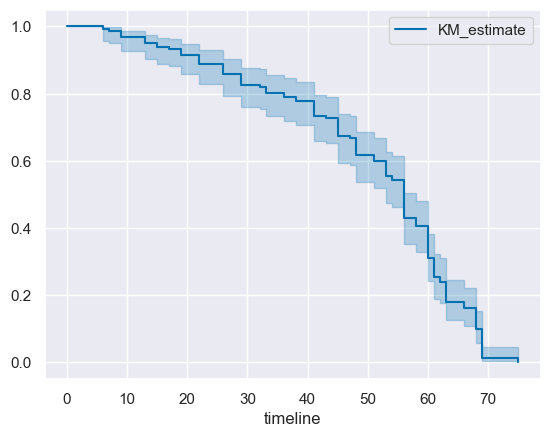

In [7]:
kmf.survival_function_
kmf.cumulative_density_
kmf.plot_survival_function()

In [9]:
df['group']

0      miR-137
1      miR-137
2      miR-137
3      miR-137
4      miR-137
        ...   
158    control
159    control
160    control
161    control
162    control
Name: group, Length: 163, dtype: object